# 2D Acoustic Wave Equation, Scaled
---

Consider the 2d acoustic wave equation
$$
\begin{aligned}
&\frac{\partial p}{\partial t} = -c^2(x, z)\rho(x, z)\left(\frac{\partial u}{\partial x} + \frac{\partial v}{\partial z}\right) + f(x, z, t) \\
&\frac{\partial u}{\partial t} = -\frac{1}{\rho(x, z)}\frac{\partial p}{\partial x} \\
&\frac{\partial v}{\partial t} = -\frac{1}{\rho(x, z)}\frac{\partial p}{\partial z},
\end{aligned}
$$
where $p$ is Pressure, $u, v$ are the $x, z-$components of Particle Velocity, $c, \rho$ are Medium Velocity and Density.

The RHS
$$
f(x, z, t) = R(t)\times 1_{\{x = x_s, z = z_s, t\}} 
$$
is the source term, represented by a Ricker wavelet
$$
R(t) = \left(1-2(\pi f_0(t-t_0))^2\right)\exp\left(-(\pi f_0(t-t_0))^2\right),
$$
where $f_0 = 50$ is the dominant frequency, $t_0 = 0.05$ is time delay.

<p style="color:red"> We can probably use the same technique as the numerical code, i.e., $f(x, z, t) = R(t)\times N(x, z)$, where $N(x, z)$ is a Gaussian centering at $(x_s, z = z_s)$ ? </p>

In this case,
$$
N(x, z) = \exp\left(-\frac{1}{\alpha^2}\left((x-x_s)^2+(z-z_s)^2\right)\right).
$$

---

## Scaling

Since the spatial and temporal domains differs in a large scale, we need to scale both domains to $[0, 1]$ before providing data directly into neural networks.

Let 
$$
x' = \frac{x}{x_0}, \ z' = \frac{z}{z_0}, \ t' = \frac{t}{t_0}, \ p' = \frac{p}{p_0}, \ u' = \frac{u}{u_0}, \ v' = \frac{v}{v_0}
$$
where $x_0, z_0, t_0, p_0, u_0, v_0)$ are scaling factors TBD.

Then the equations become
$$
\begin{aligned}
&\frac{p_0}{t_0}\frac{\partial p'}{\partial t'} = -c^2(x_0x', z_0z')\rho(x_0x', z_0z')\left(\frac{u_0}{x_0}\frac{\partial u'}{\partial x'} + \frac{v_0}{z_0}\frac{\partial v'}{\partial z'}\right) + f(x_0x', z_0z', t_0t') \\
&\frac{u_0}{t_0}\frac{\partial u'}{\partial t'} = -\frac{1}{\rho(x_0x', z_0z')}\frac{p_0}{x_0}\frac{\partial p'}{\partial x'} \\
&\frac{v_0}{t_0}\frac{\partial v'}{\partial t'} = -\frac{1}{\rho(x_0x', z_0z')}\frac{p_0}{z_0}\frac{\partial p'}{\partial z'}, 
\end{aligned}
$$

direct model: $(x', z', t') \to (p', u', v')$

inverse model: $(x', z') \to c$

Since $x, z \sim O(10^{2}),\ t\sim O(10^{-1}),\ p \sim O(10^{-3}),\ v \sim O(10^{-10})$, we can let
$$
x_0 = 1, \ z_0 = 1, \ t_0 = 1, p_0 = 10^{-3}, u_0 = 10^{-7}, v_0 = 10^{-7}.
$$

---

## Data

- $u$ is unknown
- $v_z$: Velocity in $z-$ direction; the $v$ variable in the equation
- $p$: Pressure
- $\rho(x, z)$: Medium density; We first assume it to be known as
$$
\rho(x, z) = \left\{
\begin{aligned}
&2000, &\quad z\in [100, 150], \\
&1000, &\quad \text{otherwise}.
\end{aligned}
\right.
$$

- All known data are collected in the spatial domain $(x, z) \in [1, 250]\times [1, 250]$, with grid size 5 (which means the spatial grids are {5, 10, ..., 250}. The temporal domain is $t\in [0, 0.25)$, with time step $dt = 0.0025$. This gives 100 time steps as recorded.

- The sources are located at $(x_s, z_s) = \{25, 50, \cdots, 225\} \times \{5\}$.

## Target
- Recover the direct problem $p, u, v$
- Recover the inverse problem $c$

In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import time

import sys
sys.path.append("../../")
from Seismic_wave_inversion_PINN.tf_model_utils import *
from Seismic_wave_inversion_PINN.data_utils import *

plt.rcParams.update(plt.rcParamsDefault)
tf.keras.backend.set_floatx("float32")

%load_ext autoreload
%autoreload 2

In [2]:
def generate_model(layers):
	with tf.device("/device:gpu:0"):
		a = tf.Variable(np.ones((len(layers)-2, 1)), dtype = tf.float32)

		def atanh(a, x):
			return K.tanh(a*x)

		model = keras.models.Sequential()
		for i, l in enumerate(layers[:-2]):
			model.add(keras.layers.Dense(layers[i+1], input_shape = (layers[i], ), activation = lambda x: atanh(a[i], x)))
		model.add(keras.layers.Dense(layers[-1]))

		model.a = a
	return model

N_models = 9
direct_layers = [3, 32, 32, 32, 32, 3] # (x, z, t) -> (p, u, v)
direct_models = [generate_model(direct_layers) for i in range(N_models)]

inverse_layers = [2, 32, 32, 1] # (x, z) -> (c)
inverse_model = generate_model(inverse_layers)

In [3]:
@tf.function
def rho(x, z):
	return tf.where(tf.math.logical_and(tf.greater_equal(z, 100), tf.less_equal(z, 150)),
				   2000.0,
				   1000.0)

# source
f_0 = 50.0*np.pi
alpha = 2.0

@tf.function
def R(t, t_s):
	return (1-2*(f_0*(t-t_s))**2)*tf.exp(-(f_0*(t-t_s))**2)

@tf.function
def N(x, z, x_s, z_s):
	return tf.exp(-1.0/(alpha**2) * ((x-x_s)**2 + (z-z_s)**2))

@tf.function
def f(x, z, t, x_s, z_s, t_s):
	return R(t, t_s)*N(x, z, x_s, z_s)

In [4]:
x_0 = 1.0
z_0 = 1.0
t_0 = 1.0
p_0 = 1e-3
u_0 = 1e-7
v_0 = 1e-7

In [5]:
loss_func = keras.losses.MeanSquaredError()
loss_func_2 = keras.losses.MeanSquaredError()
# def loss_func_2(x, y):
# 	return tf.sqrt(loss_func(x, y))

def get_residue_loss(tape, p, u, v, c, x, z, t, x_s, z_s, t_s):
	dp_dt = tape.gradient(p, t)
	dp_dx = tape.gradient(p, x)
	dp_dz = tape.gradient(p, z)
	du_dt = tape.gradient(u, t)
	du_dx = tape.gradient(u, x)
	dv_dt = tape.gradient(v, t)
	dv_dz = tape.gradient(v, z)
	eq1 = loss_func_2(p_0/t_0*dp_dt, -tf.square(c)*rho(x_0*x, z_0*z)*(u_0/x_0*du_dx+v_0/z_0*dv_dz)+f(x_0*x, z_0*z, t_0*t, x_s, z_s, t_s))
	eq2 = loss_func_2(u_0/t_0*du_dt, -1/rho(x_0*x, z_0*z)*p_0/x_0*dp_dx)
	eq3 = loss_func_2(v_0/t_0*dv_dt, -1/rho(x_0*x, z_0*z)*p_0/z_0*dp_dz)
	return eq1+eq2+eq3
	
# data: [x_c, z_c, t_c, 
#                x_d, z_d, t_d, p_d, v_d
#                x_i, z_i, t_i, p_i, u_i, v_i
#                x_s, z_s, t_s]
def step(data_sources):
	losses = []
	with tf.GradientTape(persistent = True) as tape:
		tape.watch([x for d in data_sources for x in d])
		for (data, direct_model) in zip(data_sources, direct_models):
			[x_c, z_c, t_c, x_d, z_d, t_d, p_d, v_d, x_i, z_i, t_i, p_i, u_i, v_i, x_s, z_s, t_s] = data
			out_c = direct_model(tf.concat([x_c, z_c, t_c], axis = 1))
			c_c = inverse_model(tf.concat([x_c, z_c], axis = 1))
			out_d = direct_model(tf.concat([x_d, z_d, t_d], axis = 1))
			c_d = inverse_model(tf.concat([x_d, z_d], axis = 1))
			out_i = direct_model(tf.concat([x_i, z_i, t_i], axis = 1))
			c_i = inverse_model(tf.concat([x_i, z_i], axis = 1))
			loss_c = get_residue_loss(tape, out_c[:, 0:1], out_c[:, 1:2], out_c[:, 2:3], c_c, x_c, z_c, t_c, x_s, z_s, t_s)
			loss_dr = get_residue_loss(tape, out_d[:, 0:1], out_d[:, 1:2], out_d[:, 2:3], c_d, x_d, z_d, t_d, x_s, z_s, t_s)
			loss_dv_v = loss_func_2(out_d[:, 2:3], v_d)
			loss_dv_p = loss_func_2(out_d[:, 0:1], p_d)
			
			loss_ir = get_residue_loss(tape, out_i[:, 0:1], out_i[:, 1:2], out_i[:, 2:3], c_i, x_i, z_i, t_i, x_s, z_s, t_s)
			loss_iv_p = loss_func_2(out_i[:, 0:1], p_i)
			loss_iv_u = loss_func_2(out_i[:, 1:2], u_i)
			loss_iv_v = loss_func_2(out_i[:, 2:3], v_i)
			losses.append([loss_c, loss_dr, loss_ir, loss_dv_p, loss_dv_v, loss_iv_p, loss_iv_u, loss_iv_v])
# 			tf.print(losses)
# 			tf.print("p_d", loss_func(out_d[:, 0:1], p_d))
# 			tf.print("v_d", loss_func(out_d[:, 2:3], v_d))
# 			tf.print("p_i", loss_func(out_i[:, 0:1], p_i))
# 			tf.print("u_i", loss_func(out_i[:, 1:2], u_i))
# 			tf.print("v_i", loss_func(out_i[:, 2:3], v_i))


		loss_c = sum([l[0] for l in losses])
		loss_dr = sum([l[1] for l in losses])
		loss_ir = sum([l[2] for l in losses])
		loss_dv_p = sum([l[3] for l in losses])
		loss_dv_v = sum([l[4] for l in losses])
		loss_iv_p = sum([l[5] for l in losses])
		loss_iv_u = sum([l[6] for l in losses])
		loss_iv_v = sum([l[7] for l in losses])
		loss = w_c*loss_c + w_dr*loss_dr + w_ir*loss_ir + w_dv_p*loss_dv_p + w_dv_v*loss_dv_v + \
				w_iv_p*loss_iv_p + w_iv_u*loss_iv_u + w_iv_v*loss_iv_v
	grads = tape.gradient(loss, [v for model in direct_models for v in model.trainable_variables] + \
						  inverse_model.trainable_variables + [model.a for model in direct_models])
	optimizer.apply_gradients(zip(grads, [v for model in direct_models for v in model.trainable_variables] + \
								  inverse_model.trainable_variables + [model.a for model in direct_models]))
	del tape
	return loss, loss_c, loss_dr, loss_ir, loss_dv_p, loss_dv_v, loss_iv_p, loss_iv_u, loss_iv_v

# d_s, d_i, d_c, d_d: dataset for each source


# data_sources: [d_1, ..., d_s]; dataset for each source
# d_j: [d_j_i, d_j_c, d_j_d, d_j_s]
# d_j_i: [x_i, z_i, t_i, p_i, u_i, v_i]
# d_j_c: [x_c, z_c, t_c]
# d_j_d: [x_d, z_d, t_d, p_d, v_d]
# d_j_s: [x_s, z_s, t_s]
def train(data_sources, epochs, batch_proportion = 0.1, print_every = 100, save_every = 10000, save_path = None):
	shuffled = lambda dataset: [tf.data.Dataset.from_tensor_slices(tuple(d)).shuffle(buffer_size = max(d[0].shape[0], 1), \
                                                        reshuffle_each_iteration = True).batch(max(int(batch_proportion*d[0].shape[0]), 1)) \
                                        for d in dataset]
	data_s = shuffled([d for d_s in data_sources for d in d_s[:-1]])
	source_locations = [d[-1] for d in data_sources]
	for epoch in range(1, epochs+1):
		losses = np.zeros((9,))
		for d in zip(*data_s): # d: [d_1_i, d_1_c, d_1_d, d_2_i, ...]
			data_sources = [list(d[i*3+1])+list(d[i*3+2])+list(d[i*3])+source_locations[i] for i in range(n_sources)]
			loss = step(data_sources)
			losses += np.array(loss)
		losses *= batch_proportion
		
		if epoch % print_every == 0:
			print("{}, Epoch: {}, Loss: {:.4e}, loss_c: {:.4e}, loss_dr: {:.4e}, loss_ir: {:.4e}, loss_dv_p: {:.4e}, loss_dv_v: {:.4e}, loss_iv_p: {:.4e}, loss_iv_u: {:.4e}, loss_iv_v: {:.4e}".format(get_time(), epoch, *list(losses)))

		if epoch % save_every == 0:
			for i, model in enumerate(direct_models):
				model.save("models/0624_9_direct_models_scaled_equation/{}/direct_model_{}/".format(save_path, i))
			inverse_model.save("models/0624_9_direct_models_scaled_equation/{}/inverse_model".format(save_path))

In [6]:
from scipy.io import loadmat

x_s = np.linspace(25.0, 225.0, 9)
z_s = 5.0
t_s = 0.05
n_sources = len(x_s)

domain = [0, 250]
T_max = 0.25
dx = 5
dt = 0.0025

x_d = np.linspace(5.0, 250.0, 50) / x_0
z_d = np.array([5.0]) / z_0
t_d = np.linspace(0.0, 0.2475, 100) / t_0

n_c = 1000
x_c = transform(np.random.random((n_c, 1)), *domain) / x_0
z_c = transform(np.random.random((n_c, 1)), *domain) / z_0
t_c = transform(np.random.random((n_c, 1)), 0, T_max) / t_0

n_s = 1000
x_c_source = np.vstack([transform(np.random.random((n_s, 1)), xi-5, xi+5) for xi in x_s]) / x_0
z_c_source = np.vstack([transform(np.random.random((n_s, 1)), z_s-5, z_s+5) for i in x_s]) / z_0
t_c_source = np.vstack([transform(np.random.random((n_s, 1)), t_s-0.05, t_s+0.05) for i in x_s]) / t_0

x_c = np.vstack([x_c, x_c_source])
z_c = np.vstack([z_c, z_c_source])
t_c = np.vstack([t_c, t_c_source])

n_i = 1000
x_i = transform(np.random.random((n_i, 1)), *domain) / x_0
z_i = transform(np.random.random((n_i, 1)), *domain) / z_0
t_i = np.zeros_like(x_i) / t_0
p_i = np.zeros_like(x_i) / p_0
u_i = np.zeros_like(x_i) / u_0
v_i = np.zeros_like(x_i) / v_0

# txz_c = tensor_grid([t_c, x_c, z_c])
txz_d = tensor_grid([t_d, x_d, z_d])

map_to_tf_float32 = lambda x: list(map(lambda y: tf.constant(y, dtype = tf.float32), x))

data_sources = []
for x in x_s:
	p = loadmat("data/sr_p_{}.mat".format(int(x/5)))["sr"].reshape((-1, 1)) / p_0
	v = loadmat("data/sr_vz_{}.mat".format(int(x/5)))["sr"].reshape((-1, 1)) / v_0
	d_i = map_to_tf_float32([x_i, z_i, t_i, p_i, u_i, v_i])
# 	d_c = map_to_tf_float32([txz_c[:, 1:2], txz_c[:, 2:3], txz_c[:, 0:1]])
	d_c = map_to_tf_float32([x_c, z_c, t_c])
	d_d = map_to_tf_float32([txz_d[:, 1:2], txz_d[:, 2:3], txz_d[:, 0:1], p, v])
	d_s = map_to_tf_float32([x, z_s, t_s])
	data_sources.append([d_i, d_c, d_d, d_s])

In [8]:
i = 1
optimizer = keras.optimizers.Adam(lr = 1e-4)
w_c, w_dr, w_ir, w_dv_p, w_dv_v, w_iv_p, w_iv_u, w_iv_v = 1.0, 1.0, 1.0, 1e4, 1e4, 1.0, 0.0, 0.0

train(data_sources, 10000, batch_proportion = 1.0, print_every = 10, save_every = 1000, save_path = "{}_adam".format(i))

2020/06/25, 08:43:08, Epoch: 10, Loss: 8.6714e+03, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 1.5337e-09, loss_dv_p: 1.9979e-01, loss_dv_v: 6.6725e-01, loss_iv_p: 1.0381e+00, loss_iv_u: 3.1107e+00, loss_iv_v: 1.2212e+00
2020/06/25, 08:43:34, Epoch: 20, Loss: 4.3791e+03, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 1.5087e-09, loss_dv_p: 1.3776e-01, loss_dv_v: 3.0005e-01, loss_iv_p: 9.4390e-01, loss_iv_u: 2.9792e+00, loss_iv_v: 9.9262e-01
2020/06/25, 08:44:00, Epoch: 30, Loss: 2.5000e+03, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 1.4984e-09, loss_dv_p: 1.1346e-01, loss_dv_v: 1.3644e-01, loss_iv_p: 8.6396e-01, loss_iv_u: 2.8899e+00, loss_iv_v: 8.3012e-01
2020/06/25, 08:44:26, Epoch: 40, Loss: 1.4688e+03, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 1.4891e-09, loss_dv_p: 8.9382e-02, loss_dv_v: 5.7419e-02, loss_iv_p: 7.8749e-01, loss_iv_u: 2.8329e+00, loss_iv_v: 6.9919e-01
2020/06/25, 08:44:52, Epoch: 50, Loss: 1.0332e+03, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, 

2020/06/25, 08:58:50, Epoch: 370, Loss: 4.6370e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 1.1728e-09, loss_dv_p: 4.5681e-02, loss_dv_v: 6.5127e-04, loss_iv_p: 3.6824e-01, loss_iv_u: 2.5831e+00, loss_iv_v: 3.5398e-01
2020/06/25, 08:59:17, Epoch: 380, Loss: 4.6277e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 1.1722e-09, loss_dv_p: 4.5625e-02, loss_dv_v: 6.1550e-04, loss_iv_p: 3.6543e-01, loss_iv_u: 2.5834e+00, loss_iv_v: 3.5292e-01
2020/06/25, 08:59:43, Epoch: 390, Loss: 4.6190e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 1.1704e-09, loss_dv_p: 4.5571e-02, loss_dv_v: 5.8208e-04, loss_iv_p: 3.6281e-01, loss_iv_u: 2.5838e+00, loss_iv_v: 3.5192e-01
2020/06/25, 09:00:09, Epoch: 400, Loss: 4.6108e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 1.1674e-09, loss_dv_p: 4.5520e-02, loss_dv_v: 5.5085e-04, loss_iv_p: 3.6037e-01, loss_iv_u: 2.5841e+00, loss_iv_v: 3.5098e-01
2020/06/25, 09:00:35, Epoch: 410, Loss: 4.6030e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e

2020/06/25, 09:14:33, Epoch: 730, Loss: 4.4944e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 1.0993e-09, loss_dv_p: 4.4761e-02, loss_dv_v: 1.4969e-04, loss_iv_p: 3.2142e-01, loss_iv_u: 2.5922e+00, loss_iv_v: 3.3160e-01
2020/06/25, 09:14:59, Epoch: 740, Loss: 4.4933e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 1.0962e-09, loss_dv_p: 4.4754e-02, loss_dv_v: 1.4618e-04, loss_iv_p: 3.2077e-01, loss_iv_u: 2.5925e+00, loss_iv_v: 3.3112e-01
2020/06/25, 09:15:25, Epoch: 750, Loss: 4.4923e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 1.0934e-09, loss_dv_p: 4.4747e-02, loss_dv_v: 1.4285e-04, loss_iv_p: 3.2014e-01, loss_iv_u: 2.5927e+00, loss_iv_v: 3.3065e-01
2020/06/25, 09:15:51, Epoch: 760, Loss: 4.4913e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 1.0908e-09, loss_dv_p: 4.4740e-02, loss_dv_v: 1.3968e-04, loss_iv_p: 3.1952e-01, loss_iv_u: 2.5929e+00, loss_iv_v: 3.3017e-01
2020/06/25, 09:16:18, Epoch: 770, Loss: 4.4904e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e

2020/06/25, 09:27:43, Epoch: 1030, Loss: 4.4779e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 1.0525e-09, loss_dv_p: 4.4660e-02, loss_dv_v: 8.7255e-05, loss_iv_p: 3.0491e-01, loss_iv_u: 2.6001e+00, loss_iv_v: 3.1800e-01
2020/06/25, 09:28:09, Epoch: 1040, Loss: 4.4776e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 1.0511e-09, loss_dv_p: 4.4659e-02, loss_dv_v: 8.5976e-05, loss_iv_p: 3.0439e-01, loss_iv_u: 2.6004e+00, loss_iv_v: 3.1757e-01
2020/06/25, 09:28:35, Epoch: 1050, Loss: 4.4774e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 1.0498e-09, loss_dv_p: 4.4658e-02, loss_dv_v: 8.4724e-05, loss_iv_p: 3.0387e-01, loss_iv_u: 2.6006e+00, loss_iv_v: 3.1715e-01
2020/06/25, 09:29:02, Epoch: 1060, Loss: 4.4772e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 1.0484e-09, loss_dv_p: 4.4657e-02, loss_dv_v: 8.3498e-05, loss_iv_p: 3.0337e-01, loss_iv_u: 2.6010e+00, loss_iv_v: 3.1672e-01
2020/06/25, 09:29:28, Epoch: 1070, Loss: 4.4773e+02, loss_c: 2.9206e-03, loss_dr: 4.

2020/06/25, 09:45:13, Epoch: 1430, Loss: 4.4718e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 1.0010e-09, loss_dv_p: 4.4638e-02, loss_dv_v: 5.0610e-05, loss_iv_p: 2.8359e-01, loss_iv_u: 2.6099e+00, loss_iv_v: 3.0218e-01
2020/06/25, 09:45:40, Epoch: 1440, Loss: 4.4717e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 9.9967e-10, loss_dv_p: 4.4638e-02, loss_dv_v: 4.9966e-05, loss_iv_p: 2.8303e-01, loss_iv_u: 2.6101e+00, loss_iv_v: 3.0181e-01
2020/06/25, 09:46:06, Epoch: 1450, Loss: 4.4716e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 9.9837e-10, loss_dv_p: 4.4638e-02, loss_dv_v: 4.9332e-05, loss_iv_p: 2.8247e-01, loss_iv_u: 2.6103e+00, loss_iv_v: 3.0145e-01
2020/06/25, 09:46:32, Epoch: 1460, Loss: 4.4715e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 9.9707e-10, loss_dv_p: 4.4637e-02, loss_dv_v: 4.8707e-05, loss_iv_p: 2.8191e-01, loss_iv_u: 2.6105e+00, loss_iv_v: 3.0109e-01
2020/06/25, 09:46:58, Epoch: 1470, Loss: 4.4714e+02, loss_c: 2.9206e-03, loss_dr: 4.

2020/06/25, 10:00:59, Epoch: 1790, Loss: 4.4690e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 9.5579e-10, loss_dv_p: 4.4631e-02, loss_dv_v: 3.2489e-05, loss_iv_p: 2.6322e-01, loss_iv_u: 2.6155e+00, loss_iv_v: 2.9008e-01
2020/06/25, 10:01:25, Epoch: 1800, Loss: 4.4689e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 9.5451e-10, loss_dv_p: 4.4630e-02, loss_dv_v: 3.2043e-05, loss_iv_p: 2.6265e-01, loss_iv_u: 2.6156e+00, loss_iv_v: 2.8977e-01
2020/06/25, 10:01:52, Epoch: 1810, Loss: 4.4689e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 9.5323e-10, loss_dv_p: 4.4630e-02, loss_dv_v: 3.1649e-05, loss_iv_p: 2.6207e-01, loss_iv_u: 2.6157e+00, loss_iv_v: 2.8947e-01
2020/06/25, 10:02:18, Epoch: 1820, Loss: 4.4688e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 9.5196e-10, loss_dv_p: 4.4630e-02, loss_dv_v: 3.1270e-05, loss_iv_p: 2.6150e-01, loss_iv_u: 2.6158e+00, loss_iv_v: 2.8916e-01
2020/06/25, 10:02:44, Epoch: 1830, Loss: 4.4687e+02, loss_c: 2.9206e-03, loss_dr: 4.

2020/06/25, 10:15:03, Epoch: 2110, Loss: 4.4673e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 9.1703e-10, loss_dv_p: 4.4626e-02, loss_dv_v: 2.2120e-05, loss_iv_p: 2.4502e-01, loss_iv_u: 2.6193e+00, loss_iv_v: 2.8082e-01
2020/06/25, 10:15:29, Epoch: 2120, Loss: 4.4673e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 9.1595e-10, loss_dv_p: 4.4626e-02, loss_dv_v: 2.1821e-05, loss_iv_p: 2.4443e-01, loss_iv_u: 2.6194e+00, loss_iv_v: 2.8055e-01
2020/06/25, 10:15:55, Epoch: 2130, Loss: 4.4673e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 9.1489e-10, loss_dv_p: 4.4626e-02, loss_dv_v: 2.2070e-05, loss_iv_p: 2.4385e-01, loss_iv_u: 2.6195e+00, loss_iv_v: 2.8026e-01
2020/06/25, 10:16:22, Epoch: 2140, Loss: 4.4673e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 9.1381e-10, loss_dv_p: 4.4626e-02, loss_dv_v: 2.2025e-05, loss_iv_p: 2.4328e-01, loss_iv_u: 2.6197e+00, loss_iv_v: 2.7998e-01
2020/06/25, 10:16:48, Epoch: 2150, Loss: 4.4672e+02, loss_c: 2.9206e-03, loss_dr: 4.

2020/06/25, 10:32:33, Epoch: 2510, Loss: 4.4658e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 8.7777e-10, loss_dv_p: 4.4622e-02, loss_dv_v: 1.3427e-05, loss_iv_p: 2.2138e-01, loss_iv_u: 2.6237e+00, loss_iv_v: 2.7061e-01
2020/06/25, 10:32:59, Epoch: 2520, Loss: 4.4658e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 8.7691e-10, loss_dv_p: 4.4622e-02, loss_dv_v: 1.3302e-05, loss_iv_p: 2.2076e-01, loss_iv_u: 2.6238e+00, loss_iv_v: 2.7038e-01
2020/06/25, 10:33:25, Epoch: 2530, Loss: 4.4658e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 8.7607e-10, loss_dv_p: 4.4622e-02, loss_dv_v: 1.3120e-05, loss_iv_p: 2.2017e-01, loss_iv_u: 2.6239e+00, loss_iv_v: 2.7014e-01
2020/06/25, 10:33:51, Epoch: 2540, Loss: 4.4657e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 8.7523e-10, loss_dv_p: 4.4622e-02, loss_dv_v: 1.2960e-05, loss_iv_p: 2.1956e-01, loss_iv_u: 2.6240e+00, loss_iv_v: 2.6991e-01
2020/06/25, 10:34:18, Epoch: 2550, Loss: 4.4657e+02, loss_c: 2.9206e-03, loss_dr: 4.

2020/06/25, 10:48:17, Epoch: 2870, Loss: 4.4650e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 8.4883e-10, loss_dv_p: 4.4619e-02, loss_dv_v: 9.8607e-06, loss_iv_p: 1.9917e-01, loss_iv_u: 2.6267e+00, loss_iv_v: 2.6238e-01
2020/06/25, 10:48:43, Epoch: 2880, Loss: 4.4650e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 8.4804e-10, loss_dv_p: 4.4619e-02, loss_dv_v: 9.7169e-06, loss_iv_p: 1.9856e-01, loss_iv_u: 2.6270e+00, loss_iv_v: 2.6216e-01
2020/06/25, 10:49:09, Epoch: 2890, Loss: 4.4649e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 8.4718e-10, loss_dv_p: 4.4619e-02, loss_dv_v: 9.3575e-06, loss_iv_p: 1.9789e-01, loss_iv_u: 2.6269e+00, loss_iv_v: 2.6195e-01
2020/06/25, 10:49:36, Epoch: 2900, Loss: 4.4649e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 8.4632e-10, loss_dv_p: 4.4619e-02, loss_dv_v: 9.2807e-06, loss_iv_p: 1.9726e-01, loss_iv_u: 2.6269e+00, loss_iv_v: 2.6174e-01
2020/06/25, 10:50:02, Epoch: 2910, Loss: 4.4648e+02, loss_c: 2.9206e-03, loss_dr: 4.

2020/06/25, 11:02:19, Epoch: 3190, Loss: 4.4645e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 8.2061e-10, loss_dv_p: 4.4618e-02, loss_dv_v: 8.0865e-06, loss_iv_p: 1.7883e-01, loss_iv_u: 2.6309e+00, loss_iv_v: 2.5580e-01
2020/06/25, 11:02:45, Epoch: 3200, Loss: 4.4645e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 8.1969e-10, loss_dv_p: 4.4618e-02, loss_dv_v: 8.4011e-06, loss_iv_p: 1.7819e-01, loss_iv_u: 2.6307e+00, loss_iv_v: 2.5563e-01
2020/06/25, 11:03:12, Epoch: 3210, Loss: 4.4643e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 8.1871e-10, loss_dv_p: 4.4617e-02, loss_dv_v: 7.6652e-06, loss_iv_p: 1.7752e-01, loss_iv_u: 2.6307e+00, loss_iv_v: 2.5542e-01
2020/06/25, 11:03:38, Epoch: 3220, Loss: 4.4643e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 8.1782e-10, loss_dv_p: 4.4617e-02, loss_dv_v: 7.7754e-06, loss_iv_p: 1.7688e-01, loss_iv_u: 2.6309e+00, loss_iv_v: 2.5520e-01
2020/06/25, 11:04:04, Epoch: 3230, Loss: 4.4652e+02, loss_c: 2.9206e-03, loss_dr: 4.

2020/06/25, 11:19:21, Epoch: 3580, Loss: 4.4638e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 7.8432e-10, loss_dv_p: 4.4616e-02, loss_dv_v: 5.7843e-06, loss_iv_p: 1.5397e-01, loss_iv_u: 2.6353e+00, loss_iv_v: 2.4843e-01
2020/06/25, 11:19:47, Epoch: 3590, Loss: 4.4641e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 7.8337e-10, loss_dv_p: 4.4616e-02, loss_dv_v: 8.4819e-06, loss_iv_p: 1.5332e-01, loss_iv_u: 2.6355e+00, loss_iv_v: 2.4816e-01
2020/06/25, 11:20:14, Epoch: 3600, Loss: 4.4638e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 7.8249e-10, loss_dv_p: 4.4616e-02, loss_dv_v: 6.4340e-06, loss_iv_p: 1.5272e-01, loss_iv_u: 2.6354e+00, loss_iv_v: 2.4815e-01
2020/06/25, 11:20:40, Epoch: 3610, Loss: 4.4640e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 7.8156e-10, loss_dv_p: 4.4616e-02, loss_dv_v: 7.8508e-06, loss_iv_p: 1.5208e-01, loss_iv_u: 2.6359e+00, loss_iv_v: 2.4782e-01
2020/06/25, 11:21:06, Epoch: 3620, Loss: 4.4638e+02, loss_c: 2.9206e-03, loss_dr: 4.

2020/06/25, 11:36:51, Epoch: 3980, Loss: 4.4634e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 7.4867e-10, loss_dv_p: 4.4615e-02, loss_dv_v: 5.4225e-06, loss_iv_p: 1.2886e-01, loss_iv_u: 2.6393e+00, loss_iv_v: 2.4134e-01
2020/06/25, 11:38:39, Epoch: 4020, Loss: 4.4633e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 7.4536e-10, loss_dv_p: 4.4615e-02, loss_dv_v: 4.8924e-06, loss_iv_p: 1.2643e-01, loss_iv_u: 2.6394e+00, loss_iv_v: 2.4067e-01
2020/06/25, 11:39:06, Epoch: 4030, Loss: 4.4632e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 7.4456e-10, loss_dv_p: 4.4614e-02, loss_dv_v: 4.3936e-06, loss_iv_p: 1.2584e-01, loss_iv_u: 2.6396e+00, loss_iv_v: 2.4048e-01
2020/06/25, 11:39:32, Epoch: 4040, Loss: 4.4632e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 7.4376e-10, loss_dv_p: 4.4614e-02, loss_dv_v: 4.3830e-06, loss_iv_p: 1.2525e-01, loss_iv_u: 2.6398e+00, loss_iv_v: 2.4032e-01
2020/06/25, 11:39:58, Epoch: 4050, Loss: 4.4632e+02, loss_c: 2.9206e-03, loss_dr: 4.

2020/06/25, 11:53:58, Epoch: 4370, Loss: 4.4629e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 7.1521e-10, loss_dv_p: 4.4614e-02, loss_dv_v: 3.8577e-06, loss_iv_p: 1.0576e-01, loss_iv_u: 2.6386e+00, loss_iv_v: 2.3455e-01
2020/06/25, 11:54:24, Epoch: 4380, Loss: 4.4657e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 7.1421e-10, loss_dv_p: 4.4623e-02, loss_dv_v: 2.3371e-05, loss_iv_p: 1.0520e-01, loss_iv_u: 2.6388e+00, loss_iv_v: 2.3413e-01
2020/06/25, 11:54:50, Epoch: 4390, Loss: 4.4631e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 7.1336e-10, loss_dv_p: 4.4615e-02, loss_dv_v: 5.1437e-06, loss_iv_p: 1.0460e-01, loss_iv_u: 2.6381e+00, loss_iv_v: 2.3430e-01
2020/06/25, 11:55:17, Epoch: 4400, Loss: 4.4630e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 7.1244e-10, loss_dv_p: 4.4614e-02, loss_dv_v: 4.4408e-06, loss_iv_p: 1.0405e-01, loss_iv_u: 2.6379e+00, loss_iv_v: 2.3414e-01
2020/06/25, 11:55:43, Epoch: 4410, Loss: 4.4636e+02, loss_c: 2.9206e-03, loss_dr: 4.

2020/06/25, 12:09:43, Epoch: 4730, Loss: 4.4626e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 6.8342e-10, loss_dv_p: 4.4613e-02, loss_dv_v: 3.6530e-06, loss_iv_p: 8.6411e-02, loss_iv_u: 2.6330e+00, loss_iv_v: 2.2898e-01
2020/06/25, 12:10:09, Epoch: 4740, Loss: 4.4625e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 6.8256e-10, loss_dv_p: 4.4613e-02, loss_dv_v: 3.0288e-06, loss_iv_p: 8.5902e-02, loss_iv_u: 2.6327e+00, loss_iv_v: 2.2888e-01
2020/06/25, 12:10:36, Epoch: 4750, Loss: 4.4625e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 6.8173e-10, loss_dv_p: 4.4613e-02, loss_dv_v: 2.9934e-06, loss_iv_p: 8.5399e-02, loss_iv_u: 2.6324e+00, loss_iv_v: 2.2877e-01
2020/06/25, 12:11:02, Epoch: 4760, Loss: 4.4625e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 6.8091e-10, loss_dv_p: 4.4613e-02, loss_dv_v: 2.9250e-06, loss_iv_p: 8.4907e-02, loss_iv_u: 2.6323e+00, loss_iv_v: 2.2865e-01
2020/06/25, 12:11:28, Epoch: 4770, Loss: 4.4630e+02, loss_c: 2.9206e-03, loss_dr: 4.

2020/06/25, 12:23:46, Epoch: 5050, Loss: 4.4623e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 6.5751e-10, loss_dv_p: 4.4613e-02, loss_dv_v: 2.4654e-06, loss_iv_p: 7.1213e-02, loss_iv_u: 2.6234e+00, loss_iv_v: 2.2522e-01
2020/06/25, 12:24:12, Epoch: 5060, Loss: 4.4623e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 6.5676e-10, loss_dv_p: 4.4612e-02, loss_dv_v: 2.4907e-06, loss_iv_p: 7.0770e-02, loss_iv_u: 2.6231e+00, loss_iv_v: 2.2513e-01
2020/06/25, 12:24:38, Epoch: 5070, Loss: 4.4623e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 6.5601e-10, loss_dv_p: 4.4612e-02, loss_dv_v: 2.4347e-06, loss_iv_p: 7.0321e-02, loss_iv_u: 2.6228e+00, loss_iv_v: 2.2502e-01
2020/06/25, 12:25:04, Epoch: 5080, Loss: 4.4623e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 6.5525e-10, loss_dv_p: 4.4613e-02, loss_dv_v: 2.8386e-06, loss_iv_p: 6.9876e-02, loss_iv_u: 2.6224e+00, loss_iv_v: 2.2491e-01
2020/06/25, 12:25:31, Epoch: 5090, Loss: 4.4639e+02, loss_c: 2.9206e-03, loss_dr: 4.

2020/06/25, 12:39:29, Epoch: 5410, Loss: 4.4626e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 6.3030e-10, loss_dv_p: 4.4615e-02, loss_dv_v: 4.8331e-06, loss_iv_p: 5.6211e-02, loss_iv_u: 2.6077e+00, loss_iv_v: 2.2207e-01
2020/06/25, 12:39:55, Epoch: 5420, Loss: 4.4621e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 6.2947e-10, loss_dv_p: 4.4612e-02, loss_dv_v: 2.1961e-06, loss_iv_p: 5.5868e-02, loss_iv_u: 2.6074e+00, loss_iv_v: 2.2198e-01
2020/06/25, 12:40:21, Epoch: 5430, Loss: 4.4621e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 6.2870e-10, loss_dv_p: 4.4613e-02, loss_dv_v: 2.4787e-06, loss_iv_p: 5.5485e-02, loss_iv_u: 2.6071e+00, loss_iv_v: 2.2191e-01
2020/06/25, 12:40:47, Epoch: 5440, Loss: 4.4621e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 6.2798e-10, loss_dv_p: 4.4612e-02, loss_dv_v: 2.0994e-06, loss_iv_p: 5.5102e-02, loss_iv_u: 2.6064e+00, loss_iv_v: 2.2188e-01
2020/06/25, 12:41:14, Epoch: 5450, Loss: 4.4626e+02, loss_c: 2.9206e-03, loss_dr: 4.

2020/06/25, 12:55:14, Epoch: 5770, Loss: 4.4619e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 6.0097e-10, loss_dv_p: 4.4612e-02, loss_dv_v: 2.0956e-06, loss_iv_p: 4.3542e-02, loss_iv_u: 2.5886e+00, loss_iv_v: 2.1978e-01
2020/06/25, 12:55:40, Epoch: 5780, Loss: 4.4623e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 6.0018e-10, loss_dv_p: 4.4614e-02, loss_dv_v: 3.9019e-06, loss_iv_p: 4.3243e-02, loss_iv_u: 2.5881e+00, loss_iv_v: 2.1976e-01
2020/06/25, 12:56:06, Epoch: 5790, Loss: 4.4619e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 5.9938e-10, loss_dv_p: 4.4612e-02, loss_dv_v: 2.1685e-06, loss_iv_p: 4.2882e-02, loss_iv_u: 2.5872e+00, loss_iv_v: 2.1965e-01
2020/06/25, 12:56:32, Epoch: 5800, Loss: 4.4620e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 5.9861e-10, loss_dv_p: 4.4613e-02, loss_dv_v: 2.3313e-06, loss_iv_p: 4.2582e-02, loss_iv_u: 2.5863e+00, loss_iv_v: 2.1961e-01
2020/06/25, 12:56:59, Epoch: 5810, Loss: 4.4621e+02, loss_c: 2.9206e-03, loss_dr: 4.

2020/06/25, 13:09:17, Epoch: 6090, Loss: 4.4618e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 5.7258e-10, loss_dv_p: 4.4612e-02, loss_dv_v: 1.6043e-06, loss_iv_p: 3.4356e-02, loss_iv_u: 2.5692e+00, loss_iv_v: 2.1797e-01
2020/06/25, 13:09:43, Epoch: 6100, Loss: 4.4619e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 5.7154e-10, loss_dv_p: 4.4613e-02, loss_dv_v: 2.0537e-06, loss_iv_p: 3.4125e-02, loss_iv_u: 2.5687e+00, loss_iv_v: 2.1792e-01
2020/06/25, 13:10:10, Epoch: 6110, Loss: 4.4629e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 5.7050e-10, loss_dv_p: 4.4617e-02, loss_dv_v: 7.3187e-06, loss_iv_p: 3.3919e-02, loss_iv_u: 2.5683e+00, loss_iv_v: 2.1792e-01
2020/06/25, 13:10:37, Epoch: 6120, Loss: 4.4617e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 5.6955e-10, loss_dv_p: 4.4612e-02, loss_dv_v: 1.5310e-06, loss_iv_p: 3.3626e-02, loss_iv_u: 2.5675e+00, loss_iv_v: 2.1778e-01
2020/06/25, 13:11:03, Epoch: 6130, Loss: 4.4618e+02, loss_c: 2.9206e-03, loss_dr: 4.

2020/06/25, 13:26:26, Epoch: 6450, Loss: 4.4616e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 5.3964e-10, loss_dv_p: 4.4612e-02, loss_dv_v: 1.3332e-06, loss_iv_p: 2.6605e-02, loss_iv_u: 2.5547e+00, loss_iv_v: 2.1594e-01
2020/06/25, 13:26:55, Epoch: 6460, Loss: 4.4616e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 5.3874e-10, loss_dv_p: 4.4612e-02, loss_dv_v: 1.3317e-06, loss_iv_p: 2.6421e-02, loss_iv_u: 2.5545e+00, loss_iv_v: 2.1590e-01
2020/06/25, 13:27:24, Epoch: 6470, Loss: 4.4617e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 5.3784e-10, loss_dv_p: 4.4612e-02, loss_dv_v: 1.5594e-06, loss_iv_p: 2.6239e-02, loss_iv_u: 2.5545e+00, loss_iv_v: 2.1587e-01
2020/06/25, 13:27:52, Epoch: 6480, Loss: 4.4620e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 5.3691e-10, loss_dv_p: 4.4613e-02, loss_dv_v: 3.0962e-06, loss_iv_p: 2.6056e-02, loss_iv_u: 2.5543e+00, loss_iv_v: 2.1588e-01
2020/06/25, 13:28:20, Epoch: 6490, Loss: 4.4626e+02, loss_c: 2.9206e-03, loss_dr: 4.

2020/06/25, 13:43:42, Epoch: 6810, Loss: 4.4619e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 5.0732e-10, loss_dv_p: 4.4612e-02, loss_dv_v: 3.9353e-06, loss_iv_p: 2.0969e-02, loss_iv_u: 2.5456e+00, loss_iv_v: 2.1383e-01
2020/06/25, 13:44:12, Epoch: 6820, Loss: 4.4618e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 5.0636e-10, loss_dv_p: 4.4612e-02, loss_dv_v: 2.7387e-06, loss_iv_p: 2.0837e-02, loss_iv_u: 2.5453e+00, loss_iv_v: 2.1379e-01
2020/06/25, 13:44:40, Epoch: 6830, Loss: 4.4616e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 5.0550e-10, loss_dv_p: 4.4612e-02, loss_dv_v: 1.8044e-06, loss_iv_p: 2.0692e-02, loss_iv_u: 2.5451e+00, loss_iv_v: 2.1379e-01
2020/06/25, 13:45:09, Epoch: 6840, Loss: 4.4616e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 5.0466e-10, loss_dv_p: 4.4612e-02, loss_dv_v: 1.4039e-06, loss_iv_p: 2.0586e-02, loss_iv_u: 2.5449e+00, loss_iv_v: 2.1371e-01
2020/06/25, 13:45:39, Epoch: 6850, Loss: 4.4615e+02, loss_c: 2.9206e-03, loss_dr: 4.

2020/06/25, 13:59:11, Epoch: 7130, Loss: 4.4615e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 4.8207e-10, loss_dv_p: 4.4611e-02, loss_dv_v: 1.0501e-06, loss_iv_p: 1.7418e-02, loss_iv_u: 2.5394e+00, loss_iv_v: 2.1203e-01
2020/06/25, 13:59:40, Epoch: 7140, Loss: 4.4615e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 4.8136e-10, loss_dv_p: 4.4611e-02, loss_dv_v: 1.2773e-06, loss_iv_p: 1.7323e-02, loss_iv_u: 2.5393e+00, loss_iv_v: 2.1195e-01
2020/06/25, 14:00:09, Epoch: 7150, Loss: 4.4628e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 4.8065e-10, loss_dv_p: 4.4615e-02, loss_dv_v: 1.1345e-05, loss_iv_p: 1.7199e-02, loss_iv_u: 2.5393e+00, loss_iv_v: 2.1170e-01
2020/06/25, 14:00:37, Epoch: 7160, Loss: 4.4620e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 4.8002e-10, loss_dv_p: 4.4613e-02, loss_dv_v: 4.5876e-06, loss_iv_p: 1.7145e-02, loss_iv_u: 2.5387e+00, loss_iv_v: 2.1191e-01
2020/06/25, 14:01:06, Epoch: 7170, Loss: 4.4619e+02, loss_c: 2.9206e-03, loss_dr: 4.

2020/06/25, 14:16:27, Epoch: 7490, Loss: 4.4616e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 4.5936e-10, loss_dv_p: 4.4612e-02, loss_dv_v: 1.6674e-06, loss_iv_p: 1.4645e-02, loss_iv_u: 2.5358e+00, loss_iv_v: 2.0973e-01
2020/06/25, 14:16:57, Epoch: 7500, Loss: 4.4616e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 4.5892e-10, loss_dv_p: 4.4612e-02, loss_dv_v: 1.8067e-06, loss_iv_p: 1.4564e-02, loss_iv_u: 2.5354e+00, loss_iv_v: 2.0965e-01
2020/06/25, 14:17:25, Epoch: 7510, Loss: 4.4618e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 4.5831e-10, loss_dv_p: 4.4611e-02, loss_dv_v: 4.4194e-06, loss_iv_p: 1.4504e-02, loss_iv_u: 2.5353e+00, loss_iv_v: 2.0953e-01
2020/06/25, 14:17:54, Epoch: 7520, Loss: 4.4618e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 4.5776e-10, loss_dv_p: 4.4614e-02, loss_dv_v: 1.1826e-06, loss_iv_p: 1.4434e-02, loss_iv_u: 2.5352e+00, loss_iv_v: 2.0949e-01
2020/06/25, 14:18:23, Epoch: 7530, Loss: 4.4616e+02, loss_c: 2.9206e-03, loss_dr: 4.

2020/06/25, 14:33:44, Epoch: 7850, Loss: 4.4621e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 4.4170e-10, loss_dv_p: 4.4614e-02, loss_dv_v: 5.3659e-06, loss_iv_p: 1.2689e-02, loss_iv_u: 2.5361e+00, loss_iv_v: 2.0726e-01
2020/06/25, 14:34:14, Epoch: 7860, Loss: 4.4615e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 4.4092e-10, loss_dv_p: 4.4612e-02, loss_dv_v: 1.0037e-06, loss_iv_p: 1.2625e-02, loss_iv_u: 2.5361e+00, loss_iv_v: 2.0729e-01
2020/06/25, 14:34:44, Epoch: 7870, Loss: 4.4617e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 4.4060e-10, loss_dv_p: 4.4612e-02, loss_dv_v: 2.9844e-06, loss_iv_p: 1.2605e-02, loss_iv_u: 2.5362e+00, loss_iv_v: 2.0719e-01
2020/06/25, 14:35:12, Epoch: 7880, Loss: 4.4615e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 4.4009e-10, loss_dv_p: 4.4611e-02, loss_dv_v: 1.3814e-06, loss_iv_p: 1.2544e-02, loss_iv_u: 2.5363e+00, loss_iv_v: 2.0711e-01
2020/06/25, 14:35:41, Epoch: 7890, Loss: 4.4614e+02, loss_c: 2.9206e-03, loss_dr: 4.

2020/06/25, 14:49:14, Epoch: 8170, Loss: 4.4627e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 4.2635e-10, loss_dv_p: 4.4619e-02, loss_dv_v: 5.7039e-06, loss_iv_p: 1.1246e-02, loss_iv_u: 2.5381e+00, loss_iv_v: 2.0537e-01
2020/06/25, 14:49:42, Epoch: 8180, Loss: 4.4621e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 4.2573e-10, loss_dv_p: 4.4614e-02, loss_dv_v: 4.7161e-06, loss_iv_p: 1.1223e-02, loss_iv_u: 2.5393e+00, loss_iv_v: 2.0539e-01
2020/06/25, 14:50:11, Epoch: 8190, Loss: 4.4619e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 4.2521e-10, loss_dv_p: 4.4614e-02, loss_dv_v: 3.4433e-06, loss_iv_p: 1.1227e-02, loss_iv_u: 2.5396e+00, loss_iv_v: 2.0529e-01
2020/06/25, 14:50:40, Epoch: 8200, Loss: 4.4614e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 4.2474e-10, loss_dv_p: 4.4611e-02, loss_dv_v: 9.1317e-07, loss_iv_p: 1.1158e-02, loss_iv_u: 2.5397e+00, loss_iv_v: 2.0525e-01
2020/06/25, 14:51:10, Epoch: 8210, Loss: 4.4614e+02, loss_c: 2.9206e-03, loss_dr: 4.

2020/06/25, 15:06:35, Epoch: 8530, Loss: 4.4614e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 4.1013e-10, loss_dv_p: 4.4611e-02, loss_dv_v: 9.0104e-07, loss_iv_p: 9.8942e-03, loss_iv_u: 2.5441e+00, loss_iv_v: 2.0324e-01
2020/06/25, 15:07:03, Epoch: 8540, Loss: 4.4620e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 4.0990e-10, loss_dv_p: 4.4616e-02, loss_dv_v: 1.9750e-06, loss_iv_p: 9.8459e-03, loss_iv_u: 2.5439e+00, loss_iv_v: 2.0328e-01
2020/06/25, 15:07:33, Epoch: 8550, Loss: 4.4615e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 4.0921e-10, loss_dv_p: 4.4612e-02, loss_dv_v: 1.2453e-06, loss_iv_p: 9.8013e-03, loss_iv_u: 2.5447e+00, loss_iv_v: 2.0305e-01
2020/06/25, 15:08:02, Epoch: 8560, Loss: 4.4615e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 4.0898e-10, loss_dv_p: 4.4612e-02, loss_dv_v: 1.2794e-06, loss_iv_p: 9.7682e-03, loss_iv_u: 2.5445e+00, loss_iv_v: 2.0303e-01
2020/06/25, 15:08:31, Epoch: 8570, Loss: 4.4615e+02, loss_c: 2.9206e-03, loss_dr: 4.

2020/06/25, 15:23:58, Epoch: 8890, Loss: 4.4630e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 3.9588e-10, loss_dv_p: 4.4613e-02, loss_dv_v: 1.4993e-05, loss_iv_p: 8.6998e-03, loss_iv_u: 2.5486e+00, loss_iv_v: 2.0095e-01
2020/06/25, 15:24:26, Epoch: 8900, Loss: 4.4617e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 3.9546e-10, loss_dv_p: 4.4612e-02, loss_dv_v: 3.3042e-06, loss_iv_p: 8.6671e-03, loss_iv_u: 2.5485e+00, loss_iv_v: 2.0098e-01
2020/06/25, 15:24:56, Epoch: 8910, Loss: 4.4622e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 3.9516e-10, loss_dv_p: 4.4615e-02, loss_dv_v: 5.7974e-06, loss_iv_p: 8.6219e-03, loss_iv_u: 2.5481e+00, loss_iv_v: 2.0103e-01
2020/06/25, 15:25:26, Epoch: 8920, Loss: 4.4615e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 3.9482e-10, loss_dv_p: 4.4612e-02, loss_dv_v: 1.4023e-06, loss_iv_p: 8.6155e-03, loss_iv_u: 2.5485e+00, loss_iv_v: 2.0084e-01
2020/06/25, 15:25:54, Epoch: 8930, Loss: 4.4614e+02, loss_c: 2.9206e-03, loss_dr: 4.

2020/06/25, 15:39:28, Epoch: 9210, Loss: 4.4613e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 3.8472e-10, loss_dv_p: 4.4611e-02, loss_dv_v: 5.8465e-07, loss_iv_p: 7.8576e-03, loss_iv_u: 2.5513e+00, loss_iv_v: 1.9937e-01
2020/06/25, 15:39:57, Epoch: 9220, Loss: 4.4614e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 3.8444e-10, loss_dv_p: 4.4611e-02, loss_dv_v: 7.2361e-07, loss_iv_p: 7.8454e-03, loss_iv_u: 2.5515e+00, loss_iv_v: 1.9928e-01
2020/06/25, 15:40:26, Epoch: 9230, Loss: 4.4613e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 3.8414e-10, loss_dv_p: 4.4611e-02, loss_dv_v: 5.9898e-07, loss_iv_p: 7.8133e-03, loss_iv_u: 2.5515e+00, loss_iv_v: 1.9929e-01
2020/06/25, 15:40:55, Epoch: 9240, Loss: 4.4613e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 3.8387e-10, loss_dv_p: 4.4611e-02, loss_dv_v: 5.7113e-07, loss_iv_p: 7.7827e-03, loss_iv_u: 2.5516e+00, loss_iv_v: 1.9928e-01
2020/06/25, 15:41:24, Epoch: 9250, Loss: 4.4613e+02, loss_c: 2.9206e-03, loss_dr: 4.

2020/06/25, 15:56:51, Epoch: 9570, Loss: 4.4634e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 3.7322e-10, loss_dv_p: 4.4622e-02, loss_dv_v: 9.8452e-06, loss_iv_p: 7.0136e-03, loss_iv_u: 2.5526e+00, loss_iv_v: 1.9762e-01
2020/06/25, 15:57:20, Epoch: 9580, Loss: 4.4618e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 3.7328e-10, loss_dv_p: 4.4613e-02, loss_dv_v: 3.0074e-06, loss_iv_p: 7.0466e-03, loss_iv_u: 2.5520e+00, loss_iv_v: 1.9765e-01
2020/06/25, 15:57:49, Epoch: 9590, Loss: 4.4614e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 3.7276e-10, loss_dv_p: 4.4612e-02, loss_dv_v: 1.1608e-06, loss_iv_p: 7.0385e-03, loss_iv_u: 2.5522e+00, loss_iv_v: 1.9763e-01
2020/06/25, 15:58:18, Epoch: 9600, Loss: 4.4614e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 3.7232e-10, loss_dv_p: 4.4611e-02, loss_dv_v: 1.0049e-06, loss_iv_p: 7.0176e-03, loss_iv_u: 2.5523e+00, loss_iv_v: 1.9760e-01
2020/06/25, 15:58:47, Epoch: 9610, Loss: 4.4620e+02, loss_c: 2.9206e-03, loss_dr: 4.

2020/06/25, 16:14:09, Epoch: 9930, Loss: 4.4613e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 3.6132e-10, loss_dv_p: 4.4611e-02, loss_dv_v: 4.8748e-07, loss_iv_p: 6.4098e-03, loss_iv_u: 2.5516e+00, loss_iv_v: 1.9583e-01
2020/06/25, 16:14:38, Epoch: 9940, Loss: 4.4613e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 3.6103e-10, loss_dv_p: 4.4611e-02, loss_dv_v: 4.6800e-07, loss_iv_p: 6.3905e-03, loss_iv_u: 2.5516e+00, loss_iv_v: 1.9581e-01
2020/06/25, 16:15:07, Epoch: 9950, Loss: 4.4612e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 3.6077e-10, loss_dv_p: 4.4611e-02, loss_dv_v: 4.6309e-07, loss_iv_p: 6.3747e-03, loss_iv_u: 2.5516e+00, loss_iv_v: 1.9577e-01
2020/06/25, 16:15:36, Epoch: 9960, Loss: 4.4612e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 3.6047e-10, loss_dv_p: 4.4611e-02, loss_dv_v: 4.6087e-07, loss_iv_p: 6.3592e-03, loss_iv_u: 2.5516e+00, loss_iv_v: 1.9574e-01
2020/06/25, 16:16:05, Epoch: 9970, Loss: 4.4612e+02, loss_c: 2.9206e-03, loss_dr: 4.

In [24]:
i = 2
optimizer = keras.optimizers.Adam(lr = 1e-3)
w_c, w_dr, w_ir, w_dv_p, w_dv_v, w_iv_p, w_iv_u, w_iv_v = 1.0, 1.0, 1.0, 1e4, 1e4, 1e3, 1e3, 1e3

train(data_sources, 10000, batch_proportion = 0.2, print_every = 10, save_every = 1000, save_path = "{}_adam".format(i))

2020/06/25, 17:27:42, Epoch: 10, Loss: 4.6842e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 2.4525e-10, loss_dv_p: 4.5084e-02, loss_dv_v: 4.6785e-04, loss_iv_p: 2.8235e-03, loss_iv_u: 5.7782e-03, loss_iv_v: 4.2971e-03
2020/06/25, 17:29:33, Epoch: 20, Loss: 4.5205e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 2.1036e-10, loss_dv_p: 4.4751e-02, loss_dv_v: 5.7314e-05, loss_iv_p: 9.9717e-04, loss_iv_u: 1.6149e-03, loss_iv_v: 1.3473e-03
2020/06/25, 17:31:22, Epoch: 30, Loss: 4.5179e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 1.9630e-10, loss_dv_p: 4.4780e-02, loss_dv_v: 1.2966e-04, loss_iv_p: 7.4418e-04, loss_iv_u: 1.0747e-03, loss_iv_v: 8.5890e-04
2020/06/25, 17:33:12, Epoch: 40, Loss: 4.5136e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 1.8801e-10, loss_dv_p: 4.4782e-02, loss_dv_v: 1.3787e-04, loss_iv_p: 6.1875e-04, loss_iv_u: 8.4774e-04, loss_iv_v: 6.8824e-04
2020/06/25, 17:35:02, Epoch: 50, Loss: 4.5075e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, 

2020/06/25, 18:33:38, Epoch: 370, Loss: 4.4981e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 2.0499e-11, loss_dv_p: 4.4859e-02, loss_dv_v: 9.4236e-05, loss_iv_p: 1.2066e-04, loss_iv_u: 6.0584e-05, loss_iv_v: 8.7825e-05
2020/06/25, 18:35:27, Epoch: 380, Loss: 4.4922e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 1.8763e-11, loss_dv_p: 4.4790e-02, loss_dv_v: 1.0621e-04, loss_iv_p: 1.1958e-04, loss_iv_u: 4.1829e-05, loss_iv_v: 9.1688e-05
2020/06/25, 18:37:16, Epoch: 390, Loss: 4.4910e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 1.7330e-11, loss_dv_p: 4.4840e-02, loss_dv_v: 4.4961e-05, loss_iv_p: 1.2138e-04, loss_iv_u: 5.0312e-05, loss_iv_v: 6.4354e-05
2020/06/25, 18:39:06, Epoch: 400, Loss: 4.4844e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 1.6416e-11, loss_dv_p: 4.4752e-02, loss_dv_v: 6.2976e-05, loss_iv_p: 1.3326e-04, loss_iv_u: 8.0101e-05, loss_iv_v: 6.3925e-05
2020/06/25, 18:40:56, Epoch: 410, Loss: 4.4883e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e

2020/06/25, 19:41:15, Epoch: 740, Loss: 4.4701e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 1.3494e-12, loss_dv_p: 4.4672e-02, loss_dv_v: 2.2048e-05, loss_iv_p: 3.6115e-05, loss_iv_u: 8.0931e-06, loss_iv_v: 1.6440e-05
2020/06/25, 19:43:03, Epoch: 750, Loss: 4.4647e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 1.2710e-12, loss_dv_p: 4.4637e-02, loss_dv_v: 6.4540e-06, loss_iv_p: 1.3629e-05, loss_iv_u: 7.2734e-06, loss_iv_v: 5.8770e-06
2020/06/25, 19:44:53, Epoch: 760, Loss: 4.4677e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 1.1949e-12, loss_dv_p: 4.4647e-02, loss_dv_v: 2.4506e-05, loss_iv_p: 2.3221e-05, loss_iv_u: 7.4107e-06, loss_iv_v: 1.2960e-05
2020/06/25, 19:46:42, Epoch: 770, Loss: 4.4686e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 1.0707e-12, loss_dv_p: 4.4623e-02, loss_dv_v: 5.7238e-05, loss_iv_p: 2.2227e-05, loss_iv_u: 9.3519e-06, loss_iv_v: 2.0338e-05
2020/06/25, 19:48:30, Epoch: 780, Loss: 4.4652e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e

2020/06/25, 20:39:42, Epoch: 1060, Loss: 4.4635e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 1.7984e-13, loss_dv_p: 4.4629e-02, loss_dv_v: 4.4371e-06, loss_iv_p: 6.3141e-06, loss_iv_u: 1.9217e-06, loss_iv_v: 1.8435e-06
2020/06/25, 20:41:31, Epoch: 1070, Loss: 4.4639e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 1.7509e-13, loss_dv_p: 4.4627e-02, loss_dv_v: 1.0164e-05, loss_iv_p: 6.9142e-06, loss_iv_u: 1.1221e-06, loss_iv_v: 3.6799e-06
2020/06/25, 20:43:20, Epoch: 1080, Loss: 4.4627e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 1.5736e-13, loss_dv_p: 4.4621e-02, loss_dv_v: 4.2912e-06, loss_iv_p: 4.0045e-06, loss_iv_u: 1.2622e-06, loss_iv_v: 1.7343e-06
2020/06/25, 20:45:08, Epoch: 1090, Loss: 4.4647e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 1.5460e-13, loss_dv_p: 4.4639e-02, loss_dv_v: 5.6514e-06, loss_iv_p: 8.5778e-06, loss_iv_u: 1.0539e-06, loss_iv_v: 2.3474e-06
2020/06/25, 20:46:56, Epoch: 1100, Loss: 4.4651e+02, loss_c: 2.9206e-03, loss_dr: 4.

2020/06/25, 21:41:38, Epoch: 1420, Loss: 4.4615e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 4.9662e-15, loss_dv_p: 4.4614e-02, loss_dv_v: 2.8619e-07, loss_iv_p: 8.3607e-07, loss_iv_u: 6.0947e-08, loss_iv_v: 8.6862e-08
2020/06/25, 21:43:19, Epoch: 1430, Loss: 4.4614e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 4.8567e-15, loss_dv_p: 4.4613e-02, loss_dv_v: 4.8513e-07, loss_iv_p: 1.3527e-06, loss_iv_u: 6.0880e-08, loss_iv_v: 2.0871e-07
2020/06/25, 21:44:59, Epoch: 1440, Loss: 4.4619e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 4.0397e-15, loss_dv_p: 4.4618e-02, loss_dv_v: 3.5176e-07, loss_iv_p: 2.3798e-06, loss_iv_u: 5.4615e-08, loss_iv_v: 9.0269e-08
2020/06/25, 21:46:39, Epoch: 1450, Loss: 4.4616e+02, loss_c: 2.9206e-03, loss_dr: 4.3086e-03, loss_ir: 3.7441e-15, loss_dv_p: 4.4615e-02, loss_dv_v: 3.3999e-07, loss_iv_p: 9.4202e-07, loss_iv_u: 5.1120e-08, loss_iv_v: 9.7262e-08
2020/06/25, 21:48:20, Epoch: 1460, Loss: 4.4618e+02, loss_c: 2.9206e-03, loss_dr: 4.

KeyboardInterrupt: 

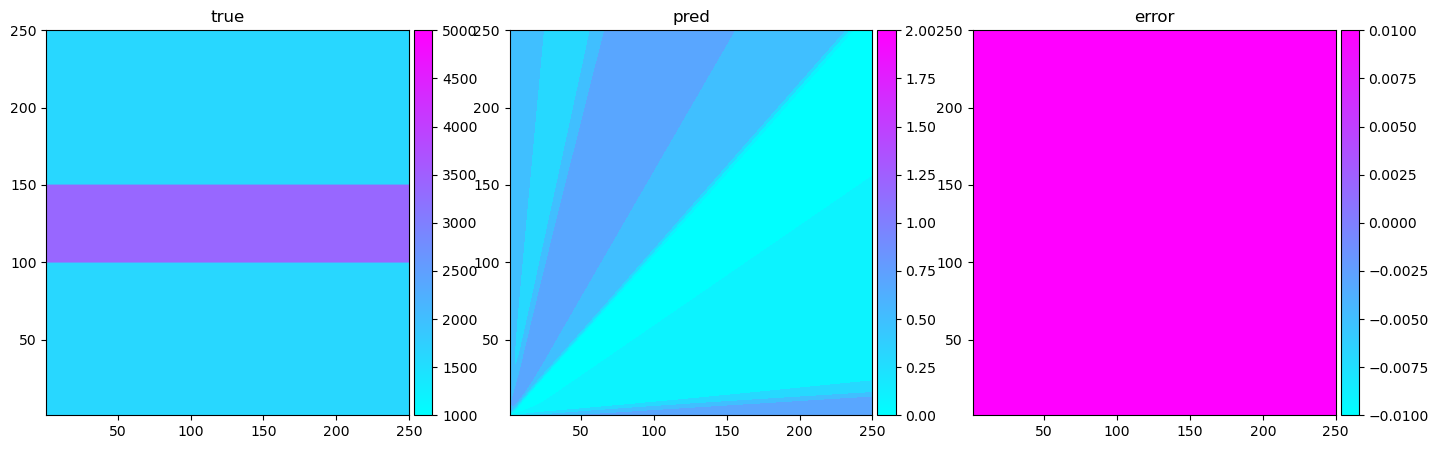

In [25]:
x_test = np.linspace(1.0, 250.0, 250) / x_0
z_test = np.linspace(1.0, 250.0, 499) / z_0
xz_test = tensor_grid([x_test, z_test])

c_pred = inverse_model(tf.constant(xz_test, dtype = tf.float32))
def c_func(x, z):
	return np.piecewise(z, [z > 150, (z >= 100) & (z <= 150), z < 100], [1500, 3500, 1500])
c_true = c_func(xz_test[:, 0:1]*x_0, xz_test[:, 1:2]*z_0)

import matplotlib as mpl
from matplotlib.cm import cool
from matplotlib.colors import Normalize

from mpl_toolkits.axes_grid1 import make_axes_locatable

cmap = cool
norm = Normalize(vmin=1000, vmax=5000)

X, Z = np.meshgrid(x_test, z_test)
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
fig.subplots_adjust(right = 1.0)

im0 = ax[0].contourf(X, Z, c_true.reshape((len(x_test), len(z_test))).T, cmap = cmap, norm = norm)
ax[0].set_title("true")
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = mpl.colors.Normalize(vmin=0, vmax=2)
im1 = ax[1].contourf(X, Z, c_pred.numpy().reshape((len(x_test), len(z_test))).T, cmap = cmap, norm = norm)
ax[1].set_title("pred")
ax[1].set_xlabel("")
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = mpl.colors.Normalize(vmin=-1e-2, vmax=1e-2)
im2 = ax[2].contourf(X, Z, c_true.reshape((len(x_test), len(z_test))).T-c_pred.numpy().reshape((len(x_test), len(z_test))).T, cmap = cmap, norm = norm)
ax[2].set_title("error")
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

plt.show()

Locator attempting to generate 1000 ticks ([7.493796601919873e-06, ..., 7.493796601921371e-06]), which exceeds Locator.MAXTICKS (1000).


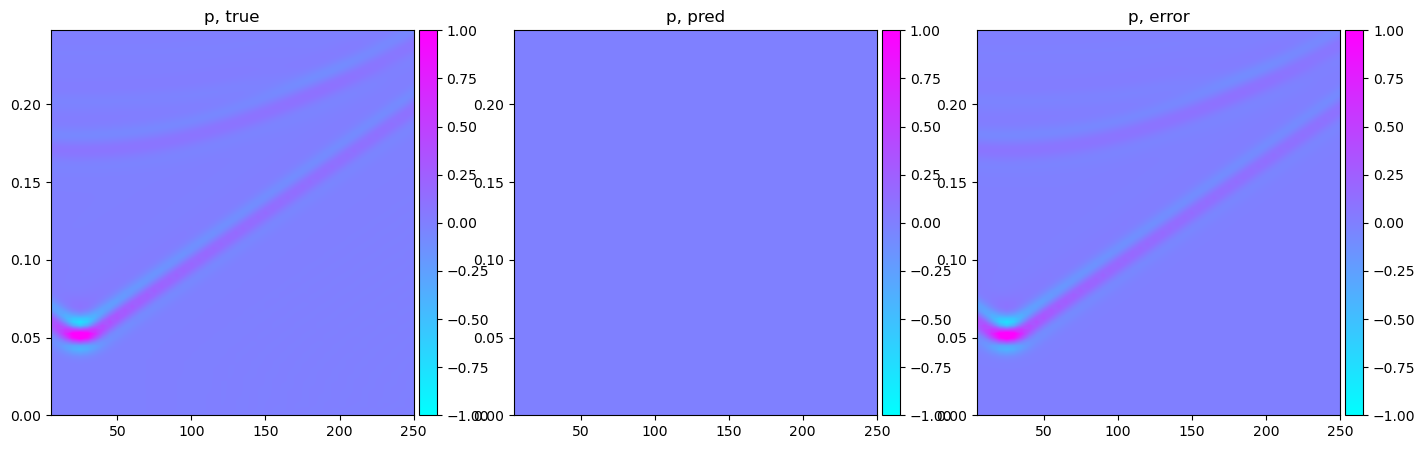

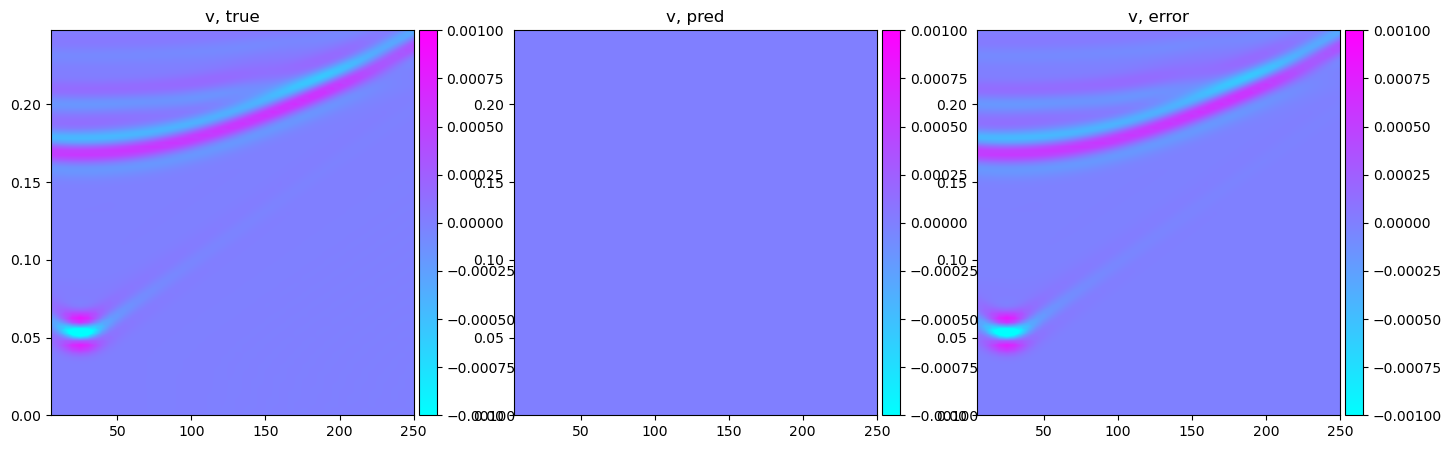

In [26]:
i = 0
p = loadmat("data/sr_p_{}.mat".format(int(x_s[i]/5)))["sr"] / p_0
v = loadmat("data/sr_vz_{}.mat".format(int(x_s[i]/5)))["sr"] / v_0

x_test = np.linspace(5.0, 250.0, 50) / x_0
# z_test = np.linspace(1.0, 250.0, 250)
z_test = np.array([0]) / z_0
t_test = np.linspace(0.0, 0.2475, 100) / t_0
xzt_test = tensor_grid([t_test, x_test, z_test])
xzt_test[:, [0, 1, 2]] = xzt_test[:, [1, 2, 0]]
out = direct_models[i](tf.constant(xzt_test, dtype = tf.float32))

cmap = cool
norm = Normalize(vmin=-1, vmax=1)

X, T = np.meshgrid(x_test, t_test)
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
fig.subplots_adjust(right = 1.0)

im0 = ax[0].contourf(X, T, p, cmap = cmap, norm = norm, levels = 1000)
ax[0].set_title("p, true")
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = Normalize(vmin=-1, vmax=1)
im1 = ax[1].contourf(X, T, out[:, 0:1].numpy().reshape((len(x_test), len(t_test))).T, cmap = cmap, norm = norm, levels = 1000)
ax[1].set_title("p, pred")
ax[1].set_xlabel("")
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = mpl.colors.Normalize(vmin=-1, vmax=1)
im2 = ax[2].contourf(X, T, p-out[:, 0:1].numpy().reshape((len(x_test), len(t_test))).T, cmap = cmap, norm = norm, levels = 1000)
ax[2].set_title("p, error")
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

###############################################################################################################

fig, ax = plt.subplots(1, 3, figsize = (15, 5))
fig.subplots_adjust(right = 1.0)

norm = Normalize(vmin=-1e-3, vmax=1e-3)
im0 = ax[0].contourf(X, T, v, cmap = cmap, norm = norm, levels = 1000)
ax[0].set_title("v, true")
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = Normalize(vmin=-1e-3, vmax=1e-3)
im1 = ax[1].contourf(X, T, out[:, 2:3].numpy().reshape((len(x_test), len(t_test))).T, cmap = cmap, norm = norm, levels = 1000)
ax[1].set_title("v, pred")
ax[1].set_xlabel("")
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = mpl.colors.Normalize(vmin=-1e-3, vmax=1e-3)
im2 = ax[2].contourf(X, T, v-out[:, 2:3].numpy().reshape((len(x_test), len(t_test))).T, cmap = cmap, norm = norm, levels = 1000)
ax[2].set_title("v, error")
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')
plt.show()

In [ ]:
p.shape